# ML - Feature Selection 

This notebook is the practical part of Feature Selection for Machine Learning. It contains methods of filtering and wrapping features and, it uses a FIFA 20 Ultimate Team Dataset. The theoretical part can be found in the following article in Medium (Portuguese). 

https://medium.com/@eduardo.p.domingues/ml-feature-selection-35cdf68f5d8c




### Data Gathering and, Wrangling 

#### Define

    - Remove columns.
    - Drop N/A.

In [2]:
import zipfile
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [41]:
# Read Players CSV

df = pd.read_csv('fut_bin20_players.csv')

/Users/Eduardo/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
# Dataframe selection 

df_clean = df.copy()

df_clean.drop(['origin', 
               'revision',
               'ps4_last',
               'ps4_min',
               'ps4_max',
               'ps4_prp',
               'xbox_last',
               'xbox_min',
               'xbox_max',
               'xbox_prp',
               'pc_last',
               'pc_min',
               'pc_max',
               'pc_prp',
               'specialities',
               'gk_diving',
               'gk_reflexes',
               'gk_handling',
               'gk_speed',
               'gk_kicking',
               'gk_positoning',
               'traits', 
               'intl_rep',
               'player_name',
               'player_extended_name',
               'club',
               'league',
               'nationality',
               'date_of_birth',
               'quality',
               'added_date',
               'base_id',
               'resource_id',
               'futbin_id',
               'pref_foot', 
               'att_workrate',
               'def_workrate'], axis=1, inplace=True)


df_clean.dropna(subset=['shooting',
                        'passing',
                        'defending',
                        'physicality',
                        'dribbling',
                        'pace'], how='all', inplace=True)


# Machine Learning

### Feature Selection

Feature selection is an important step when trying to predict a player's position. We selected the main features presented in the dataset and, now we need to verify which ones are the better when predicting the player's position. The method chosen was Sklearn Feature Selection using the function Select K Best. K is the number of features to select and, we need to compare the number of features to the mean absolute error. The mean absolute error is a risk metric corresponding to the expected value of the absolute error loss. By comparing these two variables, we get the best K variables, the ones with the lowest mean absolute error, when predicting the player's position.

Another step is encoding the categorical variables. Since we are trying to predict a categorical variable, and machine learning models only accept numbers as inputs and outputs, we need to encode the categorical variable.

In [43]:
sample = df_clean.copy()

### Preprocessing 
Split the dataset into two datasets, train and, test.

In [44]:
X = sample.drop(['position'], axis=1)
y = sample['position']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Encode - Functions

Encode Categorical Variables

In [9]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
        
    return X_train_enc, X_test_enc
    
    
# Prepare the out    
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    return y_train_enc, y_test_enc

### Filter - Functions

Functions for Chi Squared and, Classification

In [11]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel
from sklearn.metrics import cohen_kappa_score


# Features selection by Filtering
def select_features_chi2(X_train, y_train, X_test):
    selector = SelectKBest(score_func=chi2, k='all')
    
    selector.fit(X_train, y_train)
    
    # Reduce X to the selected variables
    X_train2 = selector.transform(X_train)
    X_test2 = selector.transform(X_test)
    
    return X_train2, X_test2, selector

def select_features_classif(X_train, y_train, X_test):
    selector = SelectKBest(score_func=f_classif, k='all')
    
    selector.fit(X_train, y_train)
    
    # Reduce X to the selected variables
    X_train2 = selector.transform(X_train)
    X_test2 = selector.transform(X_test)
    
    return X_train2, X_test2, selector


### Wrapper - Functions

Functions for Linear Regression, Random Forest and, Ridge.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge

def select_features_lr(X_train, y_train, X_test, k):
    
    selector_model = LinearRegression(normalize=True)
    
    selector = SelectFromModel(selector_model, max_features = k, threshold=-np.inf)

    selector.fit(X_train, y_train)
    
    # Reduce X to the selected variables
    X_train2 = selector.transform(X_train)
    X_test2 = selector.transform(X_test)
    
    return X_train2, X_test2, selector



def select_features_rf(X_train, y_train, X_test, k):
    
    selector_model = RandomForestClassifier(n_estimators=100)
    
    selector = SelectFromModel(selector_model, max_features = k, threshold=-np.inf)

    selector.fit(X_train, y_train)
    
    # Reduce X to the selected variables
    X_train2 = selector.transform(X_train)
    X_test2 = selector.transform(X_test)
    
    return X_train2, X_test2, selector



def select_features_ridge(X_train, y_train, X_test, k):
    
    selector_model = Ridge(alpha=0.1, normalize=True)
    
    selector = SelectFromModel(selector_model, max_features = k, threshold=-np.inf)

    selector.fit(X_train, y_train)
    
    # Reduce X to the selected variables
    X_train2 = selector.transform(X_train)
    X_test2 = selector.transform(X_test)
    
    return X_train2, X_test2, selector

### Filtering

In [34]:
# Encode 
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

#### Feature selection with KBest method using Pearson's Chi-Squared Test

Test each feature separately using Pearson's chi-squared test. The higher the result of the test, the most relevant the feature is. 

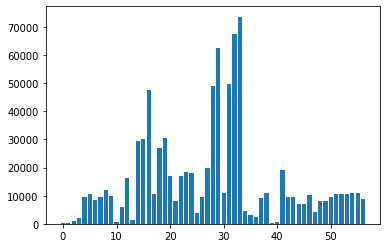

In [35]:
#X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

X_train2, X_test2, selector = select_features_chi2(X_train, y_train_enc, X_test)

plt.bar([i for i in range(len(selector.scores_))], selector.scores_);

From the graph above we can verify that features 14, 15, 16, 28, 29, 31, 32 and, 33 are the most relevant ones. 

#### Feature selection with KBest method using Mutual Information 

Mutual information evaluates the gain of each variable in the context of the target variable. Information gain measures the reduction of "surprises" by splitting a dataset according to a given value of a random variable. To sum up, larger the information gain means less surprise.

https://machinelearningmastery.com/information-gain-and-mutual-information/

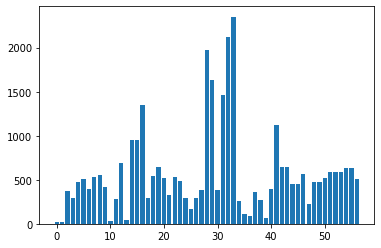

In [15]:
X_train2, X_test2, selector = select_features_classif(X_train, y_train_enc, X_test)

plt.bar([i for i in range(len(selector.scores_))], selector.scores_);

The result is similar to the one we found using Chi-Squared. Features 14, 15, 16, 28, 29, 31, 32, 33 and, 41 are the most relevant ones. 

### Wrapping

In [28]:
X_train2, X_test2, selector = select_features_lr(X_train, y_train_enc, X_test, 10)

X_train.columns[selector.get_support()]

Index(['overall', 'pass_vision', 'pass_short', 'pass_long', 'physicality',
       'weak_foot', 'skill_moves', 'lb', 'cam', 'st'],
      dtype='object')

### KBest Functions
Functions using kBest to test the best feature combinations. 

In [48]:
from sklearn.metrics import mean_absolute_error


def select_k_best(method, X_train, y_train, X_test, y_test, k):
    scores = []
    
    for k in range(2, X_train.shape[1], 2):
        X_train2, X_test2, selector = method(X_train, y_train, X_test, k)

        model = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs= -1)
        model.fit(X_train2, y_train)

        p = model.predict(X_test2)

        score = mean_absolute_error(y_test, p)

        #print(k, '___', score)

        scores.append(score)

    return scores, selector

def find_best_features(method, X_train, y_train, X_test, y_test, r):
    
    X_train2, X_test2, selector = method(X_train, y_train, X_test, r)
    
    model = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs= -1)
    model.fit(X_train2, y_train)
    
    p = model.predict(X_test2)
    
    score = mean_absolute_error(y_test, p)
    
    print(r, '___', score)
    print(X_train.columns[selector.get_support()])
    
    return selector

##### Select Best Features with Ridge

In [49]:
ridge_scores, ridge_selector = select_k_best(select_features_ridge, X_train, y_train_enc, X_test, y_test_enc, 10)



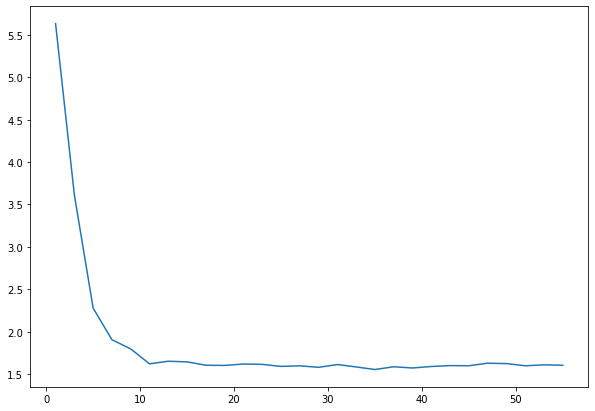

In [50]:
pd.Series(ridge_scores, index=range(1, X.shape[1], 2)).plot(figsize=(10,7));

Identify the best features.

In [51]:
n_features = 15

find_best_features(select_features_ridge, X_train, y_train_enc, X_test, y_test_enc, n_features);

15 ___ 1.628460851443882
Index(['overall', 'height', 'shoot_positioning', 'passing', 'pass_vision',
       'pass_crossing', 'pass_free_kick', 'pass_short', 'pass_long',
       'def_heading', 'weak_foot', 'skill_moves', 'cdm', 'cm', 'st'],
      dtype='object')


##### Select Best Features with Random Forest

In [59]:
rf_scores, rf_selector = select_k_best(select_features_rf, X_train, y_train_enc, X_test, y_test_enc, 10)


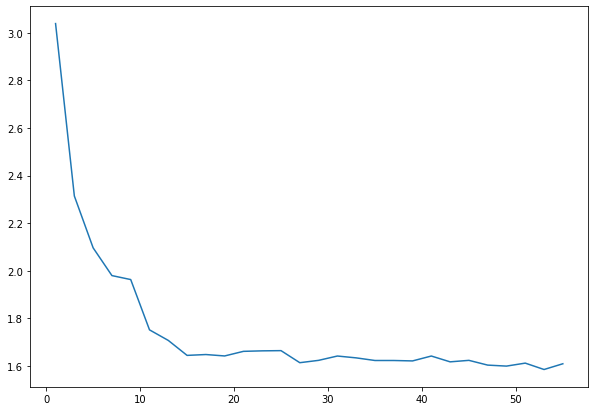

In [60]:
pd.Series(rf_scores, index=range(1, X.shape[1], 2)).plot(figsize=(10,7))

In [61]:
n_features = 15

find_best_features(select_features_rf, X_train, y_train_enc, X_test, y_test_enc, n_features);

15 ___ 1.6725215838047038
Index(['shooting', 'shoot_positioning', 'shoot_finishing', 'pass_vision',
       'pass_crossing', 'pass_long', 'defending', 'def_interceptions',
       'def_heading', 'def_marking', 'def_stand_tackle', 'def_slid_tackle',
       'phys_strength', 'cb', 'rw'],
      dtype='object')


##### Select Best Features with Linear Regression

In [56]:
lr_scores, lr_selector = select_k_best(select_features_lr, X_train, y_train_enc, X_test, y_test_enc, 10)

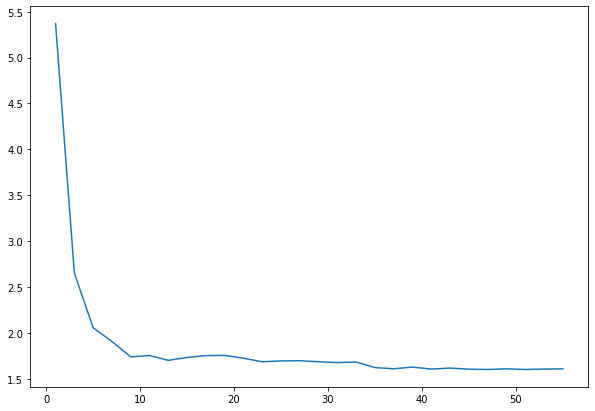

In [57]:
pd.Series(lr_scores, index=range(1, X.shape[1], 2)).plot(figsize=(10,7))

In [58]:
n_features = 20

find_best_features(select_features_lr, X_train, y_train_enc, X_test, y_test_enc, n_features);

20 ___ 1.7532003572491812
Index(['overall', 'shooting', 'passing', 'pass_vision', 'pass_short',
       'pass_long', 'defending', 'physicality', 'phys_strength', 'weak_foot',
       'skill_moves', 'cb', 'rb', 'lb', 'rm', 'lm', 'cam', 'rw', 'lw', 'st'],
      dtype='object')


#### Add new variables to the best score:

We got the best score (smaller mean absolute error) using fewer features with the Ridge method. There are many ways to tune the feature selection process after this point. We can manually add columns selected by other methods to the Ridge method and verify if there is a decrease in the error. Let's try adding physicality to the columns selected by the Ridge method.

In [67]:
new_columns = ['overall', 'height', 'shoot_positioning', 'passing', 'pass_vision',
       'pass_crossing', 'pass_free_kick', 'pass_short', 'pass_long',
       'def_heading', 'weak_foot', 'skill_moves', 'cdm', 'cm', 'st', 'physicality']



In [80]:
X_train3 = X_train[X_train.columns & new_columns]
X_test3 = X_test[X_test.columns & new_columns]

In [82]:
n_features = 16

find_best_features(select_features_ridge, X_train3, y_train_enc, X_test3, y_test_enc, n_features);


16 ___ 1.6332241738612683
Index(['overall', 'height', 'shoot_positioning', 'passing', 'pass_vision',
       'pass_crossing', 'pass_free_kick', 'pass_short', 'pass_long',
       'def_heading', 'physicality', 'weak_foot', 'skill_moves', 'cdm', 'cm',
       'st'],
      dtype='object')


By adding the column "physicality" we didn't get a smaller mean absolute error. You can try doing this to other variables selected by other methods. Feature selection is also manually adding and removing variables, checking if there is an improvement. 